In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("LVMUY.csv")

In [3]:
df_grouped = df.groupby(['Year', 'Week_Number'])['Return'].agg([np.mean,np.std])
df_grouped.reset_index(['Year', 'Week_Number'], inplace=True)
df_grouped.rename(columns={'mean': 'mean_Return_μ','std':'std_Return_σ'}, inplace=True)

In [4]:
def getWeeklyDifferences(df):
    lastClosePrice = np.asarray(df.groupby(["Year", "Week_Number"]).last()["Close"])
    firstOpenPrice = np.asarray(df.groupby(["Year", "Week_Number"]).first()["Open"])
    return lastClosePrice - firstOpenPrice
def getLabels(df):
    weeklyDifferences = getWeeklyDifferences(df)
    return [1 if x >= 0 else 0 for x in weeklyDifferences]

In [5]:
df_grouped['Weekly_Label']=getLabels(df)
df_grouped['WeeklyDif'] = getWeeklyDifferences(df)
df_grouped.dropna(inplace=True)
df_grouped

,Year,Week_Number,mean_Return_μ,std_Return_σ,Weekly_Label,WeeklyDif
0,2014,0,-0.005560,0.007863,0,-0.32
1,2014,1,-0.006661,0.017478,0,-0.82
2,2014,2,-0.000721,0.009552,0,-0.12
3,2014,3,-0.002957,0.018201,0,-1.31
4,2014,4,0.010164,0.022332,1,1.80
...,...,...,...,...,...,...
311,2019,48,-0.000431,0.012718,0,-0.54
312,2019,49,0.002777,0.006309,1,1.36
313,2019,50,0.002657,0.012763,0,-0.49
314,2019,51,0.006299,0.005811,1,1.81


In [6]:
df_train = df_grouped[df_grouped.Year == 2015]
df_pre = df_grouped[df_grouped.Year == 2016]

In [7]:
X_train, y_train = df_train[['mean_Return_μ', 'std_Return_σ']], df_train['Weekly_Label']
X_test, y_test = df_pre[['mean_Return_μ', 'std_Return_σ']], df_pre['Weekly_Label']

In [8]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
#linear SVM
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
pred_Y = svm_classifier.predict(X_test)

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
confusion_matrix(y_test, pred_Y)

array([[22,  1],
       [ 1, 28]], dtype=int64)

In [11]:
print(metrics.classification_report(y_test, pred_Y))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        23
           1       0.97      0.97      0.97        29

    accuracy                           0.96        52
   macro avg       0.96      0.96      0.96        52
weighted avg       0.96      0.96      0.96        52



The accuracy of linear SVM is: 0.96.
sensitive rate: 0.97
specificity rate: 0.96

In [12]:
# Gaussian SVM
Gsvm_classifier = svm.SVC(kernel='rbf')
Gsvm_classifier.fit(X_train, y_train)
pred_svm = Gsvm_classifier.predict(X_test)

In [13]:
confusion_matrix(y_test, pred_svm)

array([[16,  7],
       [ 3, 26]], dtype=int64)

In [14]:
print(metrics.classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.84      0.70      0.76        23
           1       0.79      0.90      0.84        29

    accuracy                           0.81        52
   macro avg       0.81      0.80      0.80        52
weighted avg       0.81      0.81      0.80        52



We can see the accucy of linear svm is higher, which is 0.83.

In [15]:
# polynomial SVM with dgree = 2
Psvm_classifier = svm.SVC(kernel='poly', degree=2)
Psvm_classifier.fit(X_train, y_train)
pred_Y = Psvm_classifier.predict(X_test)

In [16]:
print(metrics.classification_report(y_test, pred_Y))

              precision    recall  f1-score   support

           0       0.42      0.61      0.50        23
           1       0.53      0.34      0.42        29

    accuracy                           0.46        52
   macro avg       0.48      0.48      0.46        52
weighted avg       0.48      0.46      0.45        52



Based on the accuracy. Linear SVM is still better than polynomial SVM

In [17]:
#trading stratefy
test = df[df.Year == 2016]
weeklyDifferences = getWeeklyDifferences(test)
weeklyOpens = test.groupby(["Year", "Week_Number"]).first().Open
weeklyCloses = test.groupby(["Year", "Week_Number"]).last().Close

percentGains = np.asarray((weeklyCloses - weeklyOpens) / weeklyOpens)
dailyPercentGains = np.asarray((test.Close - test.Open)/test.Open)

initialInvestment = 100
buyAndHold = [initialInvestment]

In [18]:
#Buy and Hold
#PercentGains are weekly so this will take of the weeks
labels = list(range(len(percentGains) + 1))

for pg in percentGains:
    buyAndHold.append(buyAndHold[-1] * (1 + pg)) if pg >= 0 else buyAndHold.append(buyAndHold[-1] / (1 - pg) )    

In [19]:
#linear scm portfolio
svmPortfolio = [initialInvestment]

for index  in range(len(pred_svm)):
    pg = percentGains[index]
    if pred_svm[index] == 1:
        svmPortfolio.append(svmPortfolio[-1] * (1 + pg)) if pg >= 0 else svmPortfolio.append(buyAndHold[-1] / (1 - pg) )  
    else:
        svmPortfolio.append(svmPortfolio[-1])

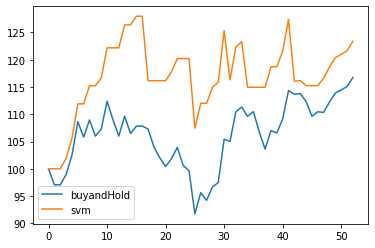

In [20]:
import matplotlib.pyplot as plt
plt.plot(labels, buyAndHold)
plt.plot(labels, svmPortfolio, label = "svm")
plt.legend(["buyandHold", "svm"], loc ="lower left")

The linear svm performed better.